In [61]:
import matplotlib.pyplot as plt
import pygame
import numpy as np
import math
import random
import copy
from matplotlib import collections  as mc

In [62]:
#### C'est le premier algo. Mutation uniquement. Pas de selection des meilleurs. 
### Tres limité

In [63]:
##### CONSTANTES

f = 0.3
rb = 5
rt = 20
dt = 0.0
m = 1
g = 9.81
k = 2
num_elites = 3
nbre_mouvements = 50
nb_gen = 20
nb_pop = 100
mutation_rate = 2/(nbre_mouvements*2)
v_max = 10

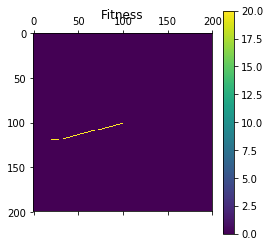

In [64]:
###### FONCTIONS UTILES

def produitvectoriel(vect1,vect2):
    return (vect1[0]*vect2[1] - vect1[1]*vect2[0])

def produitscalaire(vect1,vect2):
    return(vect1[0]*vect2[0] + vect1[1]*vect2[1])

def draw_circle(matrice,i,j,r, colour):
    for x in range(len(matrice)):
        for y in range(len(matrice[x])):
            if abs((x-i)**2 + (y-j)**2 - r**2) <r**2+1:
                matrice[x,y] = colour



def get_line(start, end):
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    is_steep = abs(dy) > abs(dx)
 
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    dx = x2 - x1
    dy = y2 - y1
    error = int(dx / 0.5)
    ystep = 1 if y1 < y2 else -1
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
    if swapped:
        points.reverse()
    return points


def draw_segment(matrice, start,end):
    points = get_line(start, end)
    for i in points:
        matrice[i[0],i[1]] = 20
        
matrice = np.zeros((200,200))
draw_segment(matrice,(100,100),(120,20))
plt.figure(1)
im1 = plt.matshow(matrice)
plt.title("Fitness")

plt.colorbar(im1)
plt.plot([])
plt.show()

In [65]:
##### CLASSE JOUEUR
class Joueur:
    
    
    
    def __init__(self, array_trou,array_balle,obstacles, nbre_mouvements):
        self.is_best = False
        self.fitness = 0
        self.partie = Partie(array_balle,array_trou,obstacles)
        self.liste_mouvements = []
        self.liste_emplacements = [array_balle]
        for i in range(nbre_mouvements):
            v = random.random()*v_max
            t = random.random()*2*np.pi
            self.liste_mouvements.append([v,t])
            
    def evaluate_fitness(self):
        
        distance = np.sqrt((self.partie.trou.position[0] - self.partie.balle.position[0])**2 + (self.partie.trou.position[1] - self.partie.balle.position[1])**2 )
        
        if self.partie.reached_goal:
            self.fitness = 3 + 10/(self.partie.nb_coups**2)
        
        else: 
            self.fitness = self.partie.nb_coups/distance**2 
            
        
    def faire_moves(self):
        for i in self.liste_mouvements:
            self.liste_emplacements.append(self.partie.deplacement(i))
    
    def mutate(self):
        for i in self.liste_mouvements:
            if random.random() < mutation_rate:
                i[0] = random.random()*v_max
            if random.random() < mutation_rate:
                i[1] = random.random()*2*np.pi
    
                

In [66]:
###### CLASSE POPULATION

class Population:
    def __init__(self, size, arraytrou, arrayballe, obstacles, nbre_mouvements):
        self.liste_joueur = []
        for i in range(size):
            self.liste_joueur.append(Joueur(arraytrou, arrayballe, obstacles, nbre_mouvements))

    def mutate_all(self,arraytrou, arrayballe, obstacles, nbre_mouvements):
        for i in range(len(self.liste_joueur)):
            self.liste_joueur[i].partie = Partie(arrayballe,arraytrou,obstacles)
            nouveauJoueur = Joueur(arraytrou, arrayballe, obstacles, nbre_mouvements)
            for j in range(nbre_mouvements):
                nouveauJoueur.liste_mouvements.append(self.liste_joueur[i].liste_mouvements[j].copy())
            nouveauJoueur.mutate()
            self.liste_joueur[i].faire_moves()
            self.liste_joueur[i].evaluate_fitness()
            nouveauJoueur.faire_moves()
            nouveauJoueur.evaluate_fitness()
            #print("nb_coups du vieux : "+ str(self.liste_joueur[i].partie.nb_coups))
            #print("nb_coups du jeune : "+ str(nouveauJoueur.partie.nb_coups))
            if nouveauJoueur.fitness > self.liste_joueur[i].fitness :
                self.liste_joueur[i] = nouveauJoueur
    
    
    def step_ga(self,size, arraytrou,arrayballe,obstacles,nbre_mouvements):
        liste = []
        
        for j in self.liste_joueur: 
            j.faire_moves()
            j.evaluate_fitness()
            
        fits = [self.liste_joueur[i].fitness for i in range(nb_pop)]
        
        for i in range(num_elites):
            liste.append(self.liste_joueur[i])
            
            
            
            
        for i in range(num_elites,nb_pop):
            parent = self.tournament_selection(k)
            partie = Partie(arrayballe,arraytrou,obstacles)
            child = Joueur(arraytrou, arrayballe, obstacles, nbre_mouvements)
            child.partie = partie
            for j in range(nbre_mouvements):
                child.liste_mouvements[j] = parent.liste_mouvements[j].copy()
            child.mutate()
            child.faire_moves()
            child.evaluate_fitness()
            liste.append(child)
            
        self.liste_joueur = liste
        
        
    def tournament_selection(self, k):
        select = []
        for i in range(k):
            select.append(random.randint(0,nb_pop-1))
        best = select[0]
        for j in select:
            if self.liste_joueur[j].fitness > self.liste_joueur[best].fitness:
                best = j
        return self.liste_joueur[best]   
        
                
    def print_partie(self,arraytrou, arrayballe, obstacles, nbre_mouvements):
        pygame.init()
        win = pygame.display.set_mode((700,700))
        pygame.display.set_caption("Le mini-golf de l'enfer")
        x_trou = int(arraytrou[0])
        y_trou = int(arraytrou[1])
        win.fill((0,128,0))
        for i in obstacles:
            pygame.draw.line(win, (0,0,0), i.depart, i.arrivee,10)

        run = True
        couleur = self.generer_couleur()
        while run :

            for i in range(nbre_mouvements): 
                pygame.time.delay(1)
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        run = False
                pygame.draw.circle(win, (0,0,0), (x_trou,y_trou), rt)
                for obs in obstacles:
                    pygame.draw.line(win, (0,0,0), obs.depart, obs.arrivee,10)
                ind_coul = 0
                for j in self.liste_joueur:
                    pygame.draw.circle(win, couleur[ind_coul], (int(j.liste_emplacements[i][0]),int(j.liste_emplacements[i][1])), rb)
                    pygame.display.update()
                    ind_coul += 1
                win.fill((0,128,0))
        print("fin")
        pygame.display.flip()
        pygame.quit()

    def generer_couleur(self):
        couleur = []
        for i in range(nb_pop):
            couleur.append((random.randint(0,250),random.randint(0,250),random.randint(0,250)))
        print(couleur)
        return couleur

In [67]:
#### CLASSE SEGMENT

class Segment:
    def __init__(self,array1,array2):
        self.depart = array1
        self.arrivee = array2
        
    def cross(self , segment):
        ab = [self.arrivee[0] - self.depart[0] , self.arrivee[1] - self.depart[1]]
        apbp = [segment.arrivee[0] - segment.depart[0] , segment.arrivee[1] - segment.depart[1]]
        abp = [segment.arrivee[0] - self.depart[0], segment.arrivee[1] - self.depart[1]]
        aap = [segment.depart[0] - self.depart[0], segment.depart[1] - self.depart[1] ]
        apb = [self.arrivee[0] - segment.depart[0] , self.arrivee[1] - segment.depart[1]]
        apa = [self.depart[0] - segment.depart[0] , self.depart[1] - segment.depart[1]]
        
        c1 = produitvectoriel(ab,apbp) != 0
        c2 = (produitvectoriel(ab,abp) * produitvectoriel(ab,aap))<=0
        c3 = (produitvectoriel(apbp,apb) * produitvectoriel(apbp,apa))<=0
        return(c1 and c2 and c3)

In [68]:

##### CLASSE TROU

class Trou:
    def __init__(self, array):
        self.position = array.copy()
 


In [69]:
##### CLASSE BALLE

class Balle:
    def __init__(self, array):
        self.position = array.copy()


In [74]:
##### CLASSE PARTIE

class Partie:
    def __init__(self, arrayballe,arraytrou, obstacles):
        self.matrice = np.zeros((700,700))
        self.balle = Balle(arrayballe)
        self.trou = Trou(arraytrou)
        self.obstacles = obstacles
        self.is_dead = False
        self.nb_coups = 1
        self.reached_goal = False 
        
    def is_won(self):
        distance = np.sqrt((self.trou.position[0] - self.balle.position[0])**2 + (self.trou.position[1] - self.balle.position[1])**2 )
       # print(distance)
        if distance < rt :
            self.reached_goal = True
    
    def is_possible_move(self,segment_dep):
        liste_obstacles_cross = []
        for i in self.obstacles: # Pour tous les obstacles
            if i.cross(segment_dep): # Si un segment_dep et i se croisent alors le move n'est pas possible
                    liste_obstacles_cross.append(i)
        if len(liste_obstacles_cross) > 0 :
            liste_distances = []
            liste_inter = []
            for i in liste_obstacles_cross:
                if (segment_dep.depart[0] - segment_dep.arrivee[0] == 0):
                    a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                    b_i = i.depart[1] - a_i *i.depart[0]
                    x_inter = segment_dep.depart[0]
                    y_inter = a_i * x_inter + b_i
                    liste_inter.append([x_inter , y_inter])
                    
                    
                elif (i.depart[0] - i.arrivee[0] == 0):
                    a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                    b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                    x_inter = i.depart[0]
                    y_inter = a_segment_dep * x_inter + b_segment_dep
                    liste_inter.append([x_inter , y_inter])
                
                else :
                    a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                    b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                    a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                    b_i = i.depart[1] - a_i *i.depart[0]
                    x_inter = (b_i - b_segment_dep) / (a_segment_dep - a_i)
                    y_inter = a_i * x_inter + b_i
                    liste_inter.append([x_inter , y_inter])
                
                liste_distances.append(np.sqrt( (x_inter - self.balle.position[0])**2 + (y_inter - self.balle.position[1])**2))
            self.balle.position[0] = liste_inter[liste_distances.index(min(liste_distances))][0]
            self.balle.position[1] = liste_inter[liste_distances.index(min(liste_distances))][1]
                
            return False
        return True
    
    def remplir_matrice(self):
        matrice = np.zeros((700,700))
        draw_circle(matrice, self.balle.position[0],self.balle.position[1],rb,1)
        draw_circle(matrice,self.trou.position[0],self.trou.position[1],rt,1)
        
    def deplacement(self,vitesse_initiale): # La vitesse sera de la forme [ ||v|| , theta)]
        distance =0.5*m/f*vitesse_initiale[0]**2
       # print(vitesse_initiale[0])
        segment_dep = Segment([self.balle.position[0],self.balle.position[1]],[self.balle.position[0] + np.cos(vitesse_initiale[1]) * distance,self.balle.position[1] + np.sin(vitesse_initiale[1]) * distance] )
        self.is_won()
        
        if self.reached_goal:
            return (self.balle.position[0],self.balle.position[1])
        if self.is_possible_move(segment_dep):
            self.nb_coups +=1
            self.balle.position[0] += np.cos(vitesse_initiale[1]) * distance
            self.balle.position[1] += np.sin(vitesse_initiale[1]) * distance  
        else :
            self.is_dead = True
            #print("La balle est sur le mur")
        return (self.balle.position[0],self.balle.position[1])

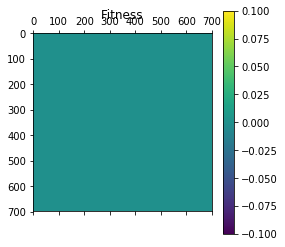

In [77]:
#DEFINITION DE LA PARTIE
obstacles = []
# On ajoute les murs
obstacles.append(Segment([0,0],[0,700]))
obstacles.append(Segment([0,0],[700,0]))
obstacles.append(Segment([700,0],[700,700]))
obstacles.append(Segment([0,700],[700,700]))
# On ajoute les obstacles
obstacles.append(Segment([300,300],[900,300]))
#obstacles.append(Segment([0,400],[400,400]))


array_balle = [100,500]
array_trou = [100,100]
population = Population(nb_pop, array_trou, array_balle, obstacles, nbre_mouvements)
partie = Partie(array_balle,array_trou, obstacles)
partie.remplir_matrice()

plt.figure(1)
mat = partie.plot_fitness()
im1 = plt.matshow(partie.matrice)
plt.title("Fitness")
plt.colorbar(im1)
plt.plot([])
plt.show()


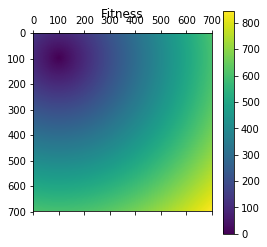

KeyboardInterrupt: 

In [76]:
#DEFINITION DE LA PARTIE
obstacles = []
# On ajoute les murs
obstacles.append(Segment([0,0],[0,700]))
obstacles.append(Segment([0,0],[700,0]))
obstacles.append(Segment([700,0],[700,700]))
obstacles.append(Segment([0,700],[700,700]))
# On ajoute les obstacles
obstacles.append(Segment([300,300],[900,300]))
#obstacles.append(Segment([0,400],[400,400]))


array_balle = [100,500]
array_trou = [100,100]
population = Population(nb_pop, array_trou, array_balle, obstacles, nbre_mouvements)
partie = Partie(array_balle,array_trou, obstacles)

plt.figure(1)
mat = partie.plot_fitness()
im1 = plt.matshow(mat)
plt.title("Fitness")
plt.colorbar(im1)
plt.plot([])
plt.show()


sumfits = []
for i in range(nb_gen):
    for j in range(len(population.liste_joueur)):
        population.liste_joueur[j].partie = Partie(array_balle,array_trou,obstacles) # On reset la partie
        population.liste_joueur[j].liste_emplacements = [array_balle]
    #if ((i+1)%10 == 0):
    print("Calculating generation : "+str(i+1))
    population.step_ga(nb_pop, array_trou,array_balle,obstacles,nbre_mouvements)
    population.liste_joueur = sorted(population.liste_joueur, key=lambda joueur: joueur.fitness, reverse = True)
    fits = [population.liste_joueur[i].fitness for i in range(nb_pop)]
    sumfits.append(sum(fits))
    
    
    
plt.figure(2)
plt.plot(sumfits)
plt.show()
    

population.print_partie(array_trou, array_balle, obstacles, nbre_mouvements)
    
    
print("La simulation est terminée.")
    






